In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import collections
import math
import scipy
import scipy.stats
import cPickle as pickle
import Queue
csv.register_dialect("textdialect", delimiter='\t')
HOME = "/home/raflynn/directionality"
! mkdir interm/nb4
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mkdir: cannot create directory `interm/nb4': File exists


In [2]:
! head interm/nb4/4Cmeta_cohesinoct4_cohesinsignal_toploopsFC1.txt

chr15	77080000	77090000	chr15	77180000	77190000
chr12	105670000	105680000	chr12	106170000	106180000
chr7	150320000	150330000	chr7	150650000	150660000
chr4	150030000	150040000	chr4	150270000	150280000
chr4	148110000	148120000	chr4	148180000	148190000
chr2	151700000	151710000	chr2	151820000	151830000
chr5	106890000	106900000	chr5	107230000	107240000
chr7	6070000	6080000	chr7	6140000	6150000
chr8	95530000	95540000	chr8	95660000	95670000
chr15	78450000	78460000	chr15	78570000	78580000


In [14]:
! cut -f1-3 interm/nb4/v65_HiChIP_cohesin_all_hiccups | sort -k1,1 > interm/nb4/cohesinleft.txt
! cut -f4-6 interm/nb4/v65_HiChIP_cohesin_all_hiccups | sort -k1,1 > interm/nb4/cohesinright.txt

! cut -f1-3 interm/nb4/v65_H3K27ac_hiccups | sort -k1,1 > interm/nb4/oct4left.txt
! cut -f4-6 interm/nb4/v65_H3K27ac_hiccups | sort -k1,1 > interm/nb4/oct4right.txt

In [5]:
! head interm/nb4/cohesinleft.txt

chr1	120460000	120470000
chr1	133890000	133900000
chr1	134010000	134020000
chr1	134930000	134940000
chr1	136040000	136050000
chr1	167700000	167710000
chr1	173290000	173300000
chr1	182190000	182200000
chr1	182190000	182200000
chr1	20920000	20930000


In [6]:
! head interm/nb1/160605_dhs_grodirec_sorted.bed

In [8]:
! head data/mESC_cStates_HMM.bed

chr1	0	3037000	13_Heterochrom	0	.	0	3037000	245,245,245
chr1	10000000	10011000	14_Heterochrom	0	.	10000000	10011000	245,245,245
chr1	10011000	10013800	2_Weak_Txn	0	.	10011000	10013800	153,255,102
chr1	10013800	10015000	1_Txn_Elongation	0	.	10013800	10015000	0,176,80
chr1	10015000	10016000	2_Weak_Txn	0	.	10015000	10016000	153,255,102
chr1	10016000	10025600	1_Txn_Elongation	0	.	10016000	10025600	0,176,80
chr1	100250800	100370400	13_Heterochrom	0	.	100250800	100370400	245,245,245
chr1	10025600	10027400	2_Weak_Txn	0	.	10025600	10027400	153,255,102
chr1	10027400	10027600	5_Active_Promoter	0	.	10027400	10027600	245,0,0
chr1	10027600	10028200	7_Active_Promoter	0	.	10027600	10028200	245,0,0


In [15]:
! bedtools intersect -a interm/nb4/cohesinleft.txt -b data/mESC_cStates_HMM.bed -wa -wb > interm/nb4/cohesinleft_HMM.txt
! bedtools intersect -a interm/nb4/cohesinright.txt -b data/mESC_cStates_HMM.bed -wa -wb > interm/nb4/cohesinright_HMM.txt
! bedtools intersect -a interm/nb4/oct4left.txt -b data/mESC_cStates_HMM.bed -wa -wb > interm/nb4/oct4left_HMM.txt
! bedtools intersect -a interm/nb4/oct4right.txt -b data/mESC_cStates_HMM.bed -wa -wb > interm/nb4/oct4right_HMM.txt

In [10]:
! head interm/nb4/cohesinleft_HMM.txt

chr1	120460000	120470000	chr1	120459600	120460600	1_Txn_Elongation	0	.	120459600	120460600	0,176,80
chr1	120460000	120470000	chr1	120460600	120466800	2_Weak_Txn	0	.	120460600	120466800	153,255,102
chr1	120460000	120470000	chr1	120466800	120468400	1_Txn_Elongation	0	.	120466800	120468400	0,176,80
chr1	120460000	120470000	chr1	120468400	120471800	2_Weak_Txn	0	.	120468400	120471800	153,255,102
chr1	133890000	133900000	chr1	133890400	133890600	9_Strong_Enhancer	0	.	133890400	133890600	250,202,0
chr1	133890000	133900000	chr1	133890600	133903200	12_Heterochrom	0	.	133890600	133903200	245,245,245
chr1	133890000	133900000	chr1	133880000	133890400	14_Heterochrom	0	.	133880000	133890400	245,245,245
chr1	134010000	134020000	chr1	134009000	134011000	2_Weak_Txn	0	.	134009000	134011000	153,255,102
chr1	134010000	134020000	chr1	134011000	134012200	1_Txn_Elongation	0	.	134011000	134012200	0,176,80
chr1	134010000	134020000	chr1	134012200	134013200	2_Weak_Txn	0	.	134012200	134013200	153,255,102


In [16]:
anchorregion = {}
files = ["interm/nb4/cohesinleft_HMM.txt","interm/nb4/cohesinright_HMM.txt","interm/nb4/oct4left_HMM.txt","interm/nb4/oct4right_HMM.txt"]
for fn in files:
    with open(fn, "r") as ifile:
        reader = csv.reader(ifile,"textdialect")
        for row in reader:
            key = "_".join(row[:3])
            value = "_".join(row[6].split("_")[1:])
            anchorregion[key] = value

In [12]:
anchorregion.keys()[:5]

['chr5_139470000_139480000',
 'chr16_17200000_17210000',
 'chr13_97820000_97830000',
 'chr18_65960000_65970000',
 'chr2_115890000_115900000']

In [13]:
anchorregion.values()[:5]

['Heterochrom', 'Heterochrom', 'Heterochrom', 'Repressed', 'Repressed']

In [17]:
cohesin = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
with open("interm/nb4/v65_HiChIP_cohesin_all_hiccups", "r") as ifile:
    reader = csv.reader(ifile,"textdialect")
    for row in reader:
        left = "_".join(row[:3])
        right = "_".join(row[3:6])
        leftreg = anchorregion[left]
        rightreg = anchorregion[right]
        cohesin[leftreg][rightreg] += 1
        cohesin[rightreg][leftreg] += 1

In [18]:
oct4 = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
with open("interm/nb4/v65_H3K27ac_hiccups", "r") as ifile:
    reader = csv.reader(ifile,"textdialect")
    for row in reader:
        left = "_".join(row[:3])
        right = "_".join(row[3:6])
        leftreg = anchorregion[left]
        rightreg = anchorregion[right]
        oct4[leftreg][rightreg] += 1
        oct4[rightreg][leftreg] += 1  # Brian

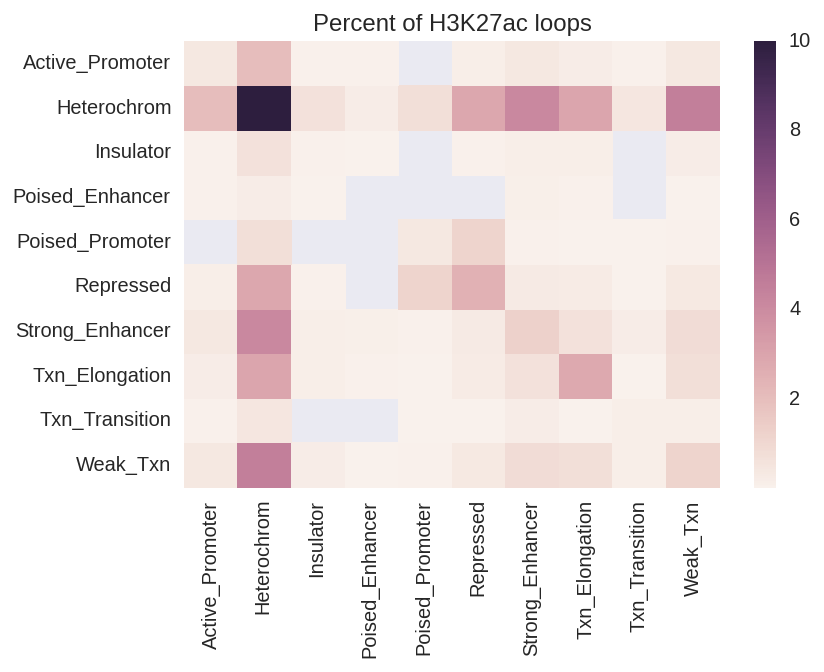

In [19]:
df = pd.DataFrame(oct4)
df = df/(np.sum(np.sum(df))) * 100
sns.heatmap(df, vmax=10)  # Brian
sns.plt.title("Percent of H3K27ac loops")
sns.plt.savefig("interm/nb4/H3K27ac_loops.pdf")  # Brian

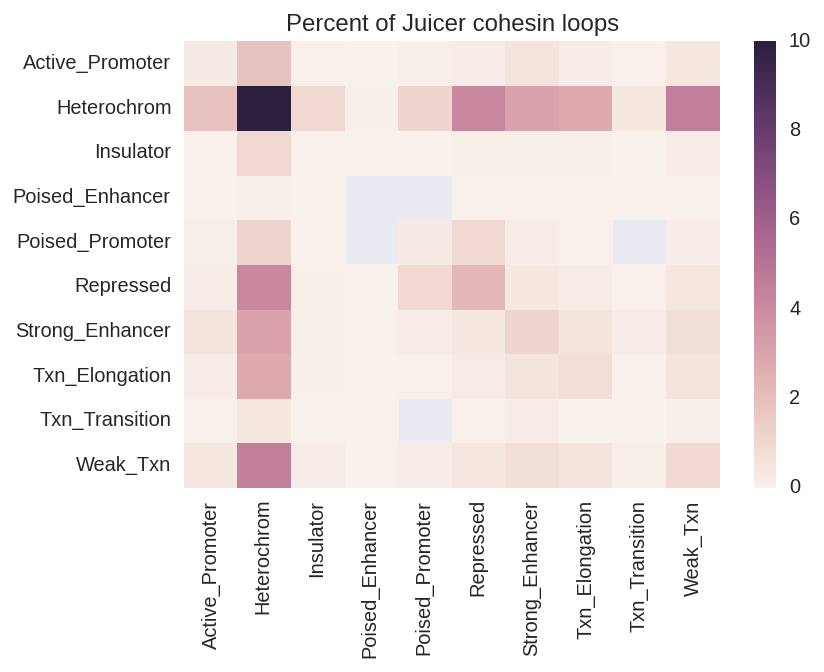

In [20]:
df = pd.DataFrame(cohesin)
df = df/(np.sum(np.sum(df))) * 100
sns.heatmap(df, vmax=10)
sns.plt.title("Percent of Juicer cohesin loops")
sns.plt.savefig("interm/nb4/Juicer_cohesin_loops.pdf")

In [23]:
np.sum(np.sum(df))

160.0